# Group 2

## Step 1: Use the estimated default probability (PD) provided in the dataset. Implement one or two surrogate model(s) to interpret the unknown model used to generate PD.

Coefficients of the linear model:
Job tenure        -0.002953
Age               -0.001269
Car price         -0.000021
Funding amount     0.000026
Down payment       0.081968
Loan duration      0.001142
Monthly payment    0.291974
Credit event       0.315471
Married           -0.072892
Homeowner         -0.064714
dtype: float64


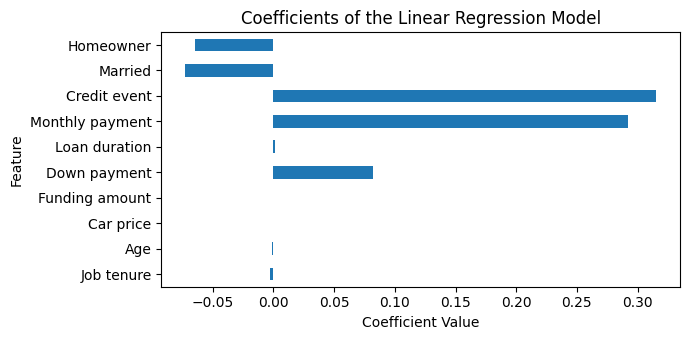

Training set performance (Linear Regression): 0.4371
Test set performance (Linear Regression): 0.4233


In [37]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

# Get the current directory
current_directory = os.path.abspath('')

# Construct the path to the Excel file
file_path = os.path.join(current_directory, 'dataproject2024.xlsx')

# Load the dataset
data = pd.read_excel(file_path)

# Select the features and the target variable (PD)
X = data[['Job tenure', 'Age', 'Car price', 'Funding amount', 'Down payment', 
          'Loan duration', 'Monthly payment', 'Credit event', 'Married', 'Homeowner']]
y = data['PD']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Surrogate Model: Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Coefficients of the linear model
coefficients = pd.Series(linear_model.coef_, index=X.columns)
print("Coefficients of the linear model:")
print(coefficients)

# Visualize the coefficients
coefficients.plot(kind='barh')
plt.title('Coefficients of the Linear Regression Model')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

# Evaluate the performance of the linear model
train_score_linear = linear_model.score(X_train, y_train)
test_score_linear = linear_model.score(X_test, y_test)
print(f'Training set performance (Linear Regression): {train_score_linear:.4f}')
print(f'Test set performance (Linear Regression): {test_score_linear:.4f}')

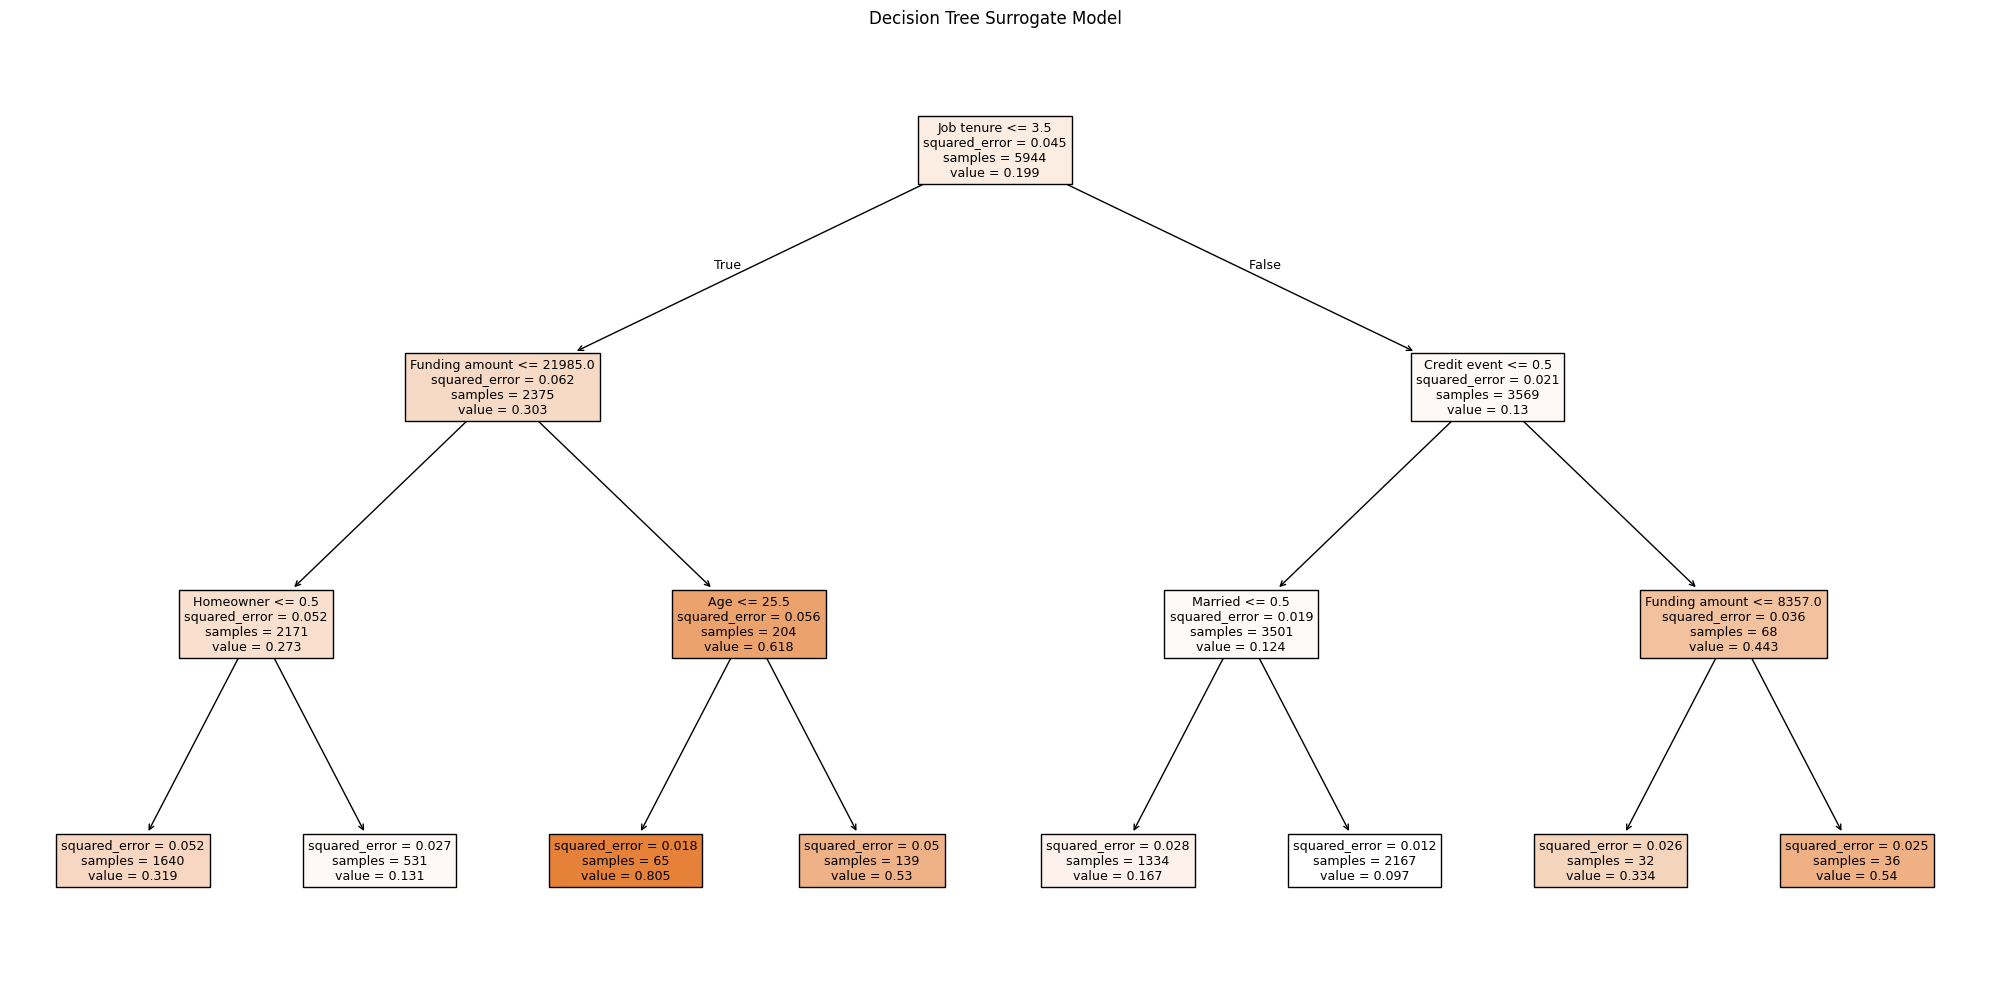

Training set performance (Decision Tree): 0.3538
Test set performance (Decision Tree): 0.3091


In [38]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

# Surrogate Model: Decision Tree
decision_tree_model = DecisionTreeRegressor(max_depth=3, random_state=42)
decision_tree_model.fit(X_train, y_train)

# Visualize the decision tree
plt.figure(figsize=(20,10))
tree.plot_tree(decision_tree_model, feature_names=X.columns, filled=True)
plt.title('Decision Tree Surrogate Model')
plt.savefig('decision_tree_surrogate_model.png')
plt.show()

# Evaluate the performance of the Decision Tree model
train_score_tree = decision_tree_model.score(X_train, y_train)
test_score_tree = decision_tree_model.score(X_test, y_test)
print(f'Training set performance (Decision Tree): {train_score_tree:.4f}')
print(f'Test set performance (Decision Tree): {test_score_tree:.4f}')

## Step 2: Estimate your own black-box machine learning model forecasting default. Each model is specific to a group of students and cannot be developed in collaboration with another group.

In [39]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import os

# Get the current directory
current_directory = os.path.abspath('')

# Construct the path to the Excel file
file_path = os.path.join(current_directory, 'dataproject2024.xlsx')

# Load the dataset
data = pd.read_excel(file_path)

# Select the features and the correct target variable (Default (y))
X = data[['Job tenure', 'Age', 'Car price', 'Funding amount', 'Down payment', 
          'Loan duration', 'Monthly payment', 'Credit event', 'Married', 'Homeowner']]
y = data['Default (y)']  # Utiliser la colonne `Default (y)` qui est binaire

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the XGBoost classifier
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X_train, y_train)

# Output basic information about the trained model
print("Model has been trained with the following parameters:")
print(xgb_model.get_params())

# Make a basic prediction on the test set (optional, just to demonstrate)
sample_predictions = xgb_model.predict(X_test[:5])
print("\nSample predictions on the test set:")
print(sample_predictions)


Model has been trained with the following parameters:
{'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}

Sample predictions on the test

## Step 3: Analyze the forecasting performance of your own model.

Accuracy of XGBoost model on training data: 0.8276
Accuracy of XGBoost model on test data: 0.8223

Confusion Matrix:
[[1160   45]
 [ 219   62]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.90      1205
           1       0.58      0.22      0.32       281

    accuracy                           0.82      1486
   macro avg       0.71      0.59      0.61      1486
weighted avg       0.79      0.82      0.79      1486



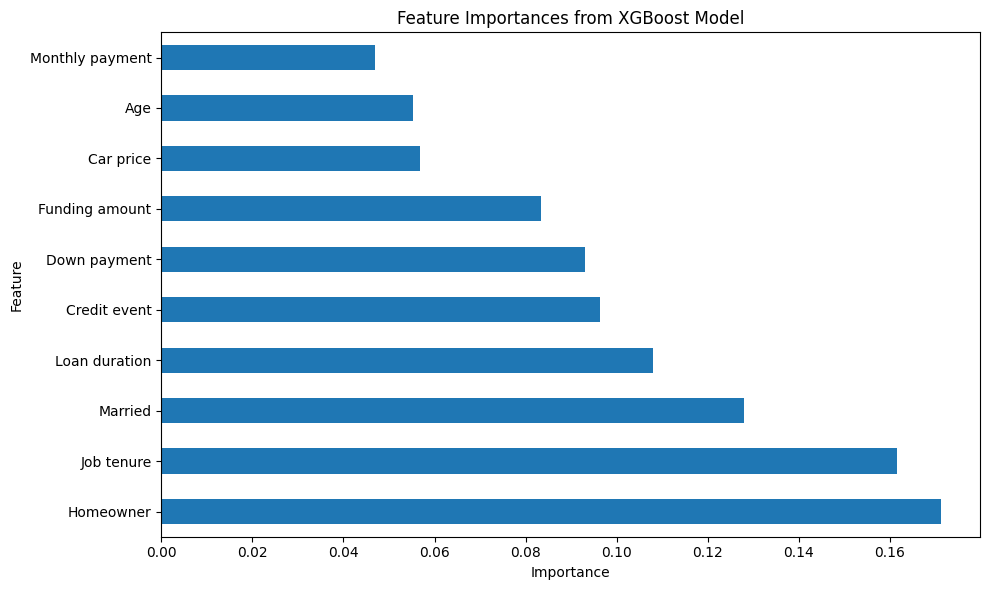


Feature importances from the XGBoost model:
Homeowner          0.171192
Job tenure         0.161454
Married            0.127870
Loan duration      0.107912
Credit event       0.096266
Down payment       0.093020
Funding amount     0.083303
Car price          0.056885
Age                0.055196
Monthly payment    0.046902
dtype: float32


In [40]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import pandas as pd

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model performance
xgb_test_accuracy = accuracy_score(y_test, y_pred)
xgb_train_accuracy = accuracy_score(y_train, xgb_model.predict(X_train))
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Display results
print(f"Accuracy of XGBoost model on training data: {xgb_train_accuracy:.4f}")
print(f"Accuracy of XGBoost model on test data: {xgb_test_accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

# Feature importances
importances = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Visualize feature importances
plt.figure(figsize=(10, 6))
importances.plot(kind='barh')
plt.title('Feature Importances from XGBoost Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

print("\nFeature importances from the XGBoost model:")
print(importances)


## Step 4: Global interpretability: Implement one or two surrogate model(s) to interpret your own model. Compare the results provided in Steps 1 and 4.

Accuracy of the logistic regression model on training data: 0.8060
Accuracy of the logistic regression model on test data: 0.8223

Coefficients of the Logistic Regression model:
Credit event       0.177423
Down payment       0.021810
Monthly payment    0.000528
Funding amount     0.000297
Car price         -0.000274
Loan duration     -0.001283
Age               -0.009785
Job tenure        -0.029094
Homeowner         -0.590883
Married           -0.646004
dtype: float64


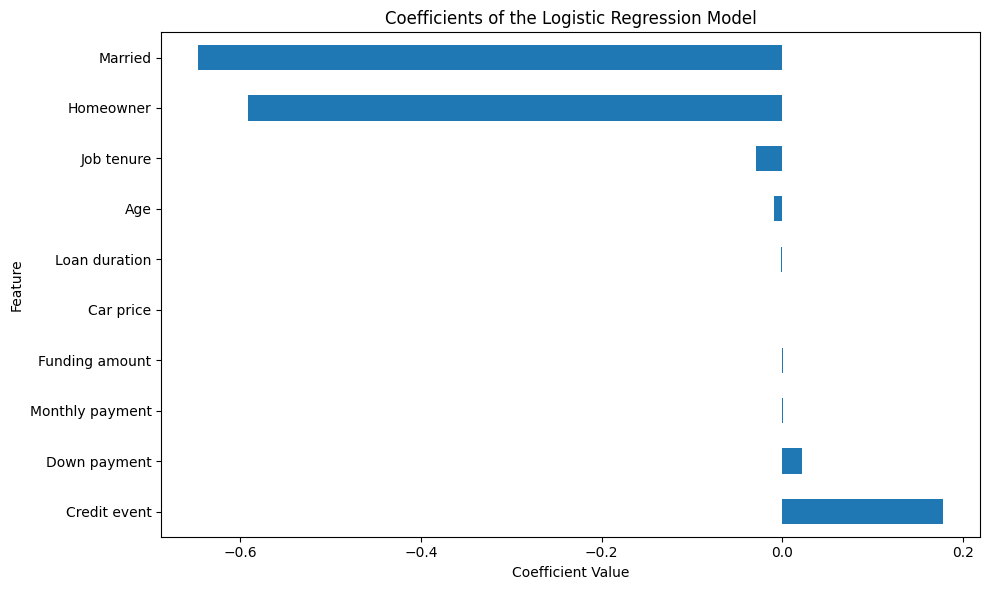

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd

# Create and train the logistic regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# Evaluate the model performance
logistic_train_accuracy = accuracy_score(y_train, logistic_model.predict(X_train))
logistic_test_accuracy = accuracy_score(y_test, logistic_model.predict(X_test))

# Display results
print(f"Accuracy of the logistic regression model on training data: {logistic_train_accuracy:.4f}")
print(f"Accuracy of the logistic regression model on test data: {logistic_test_accuracy:.4f}")

# Check and visualize the coefficients
coefficients = pd.Series(logistic_model.coef_[0], index=X.columns).sort_values(ascending=False)
print("\nCoefficients of the Logistic Regression model:")
print(coefficients)

plt.figure(figsize=(10, 6))
coefficients.plot(kind='barh')
plt.title('Coefficients of the Logistic Regression Model')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()


Accuracy of the decision tree model on training data: 0.8070
Accuracy of the decision tree model on test data: 0.8136


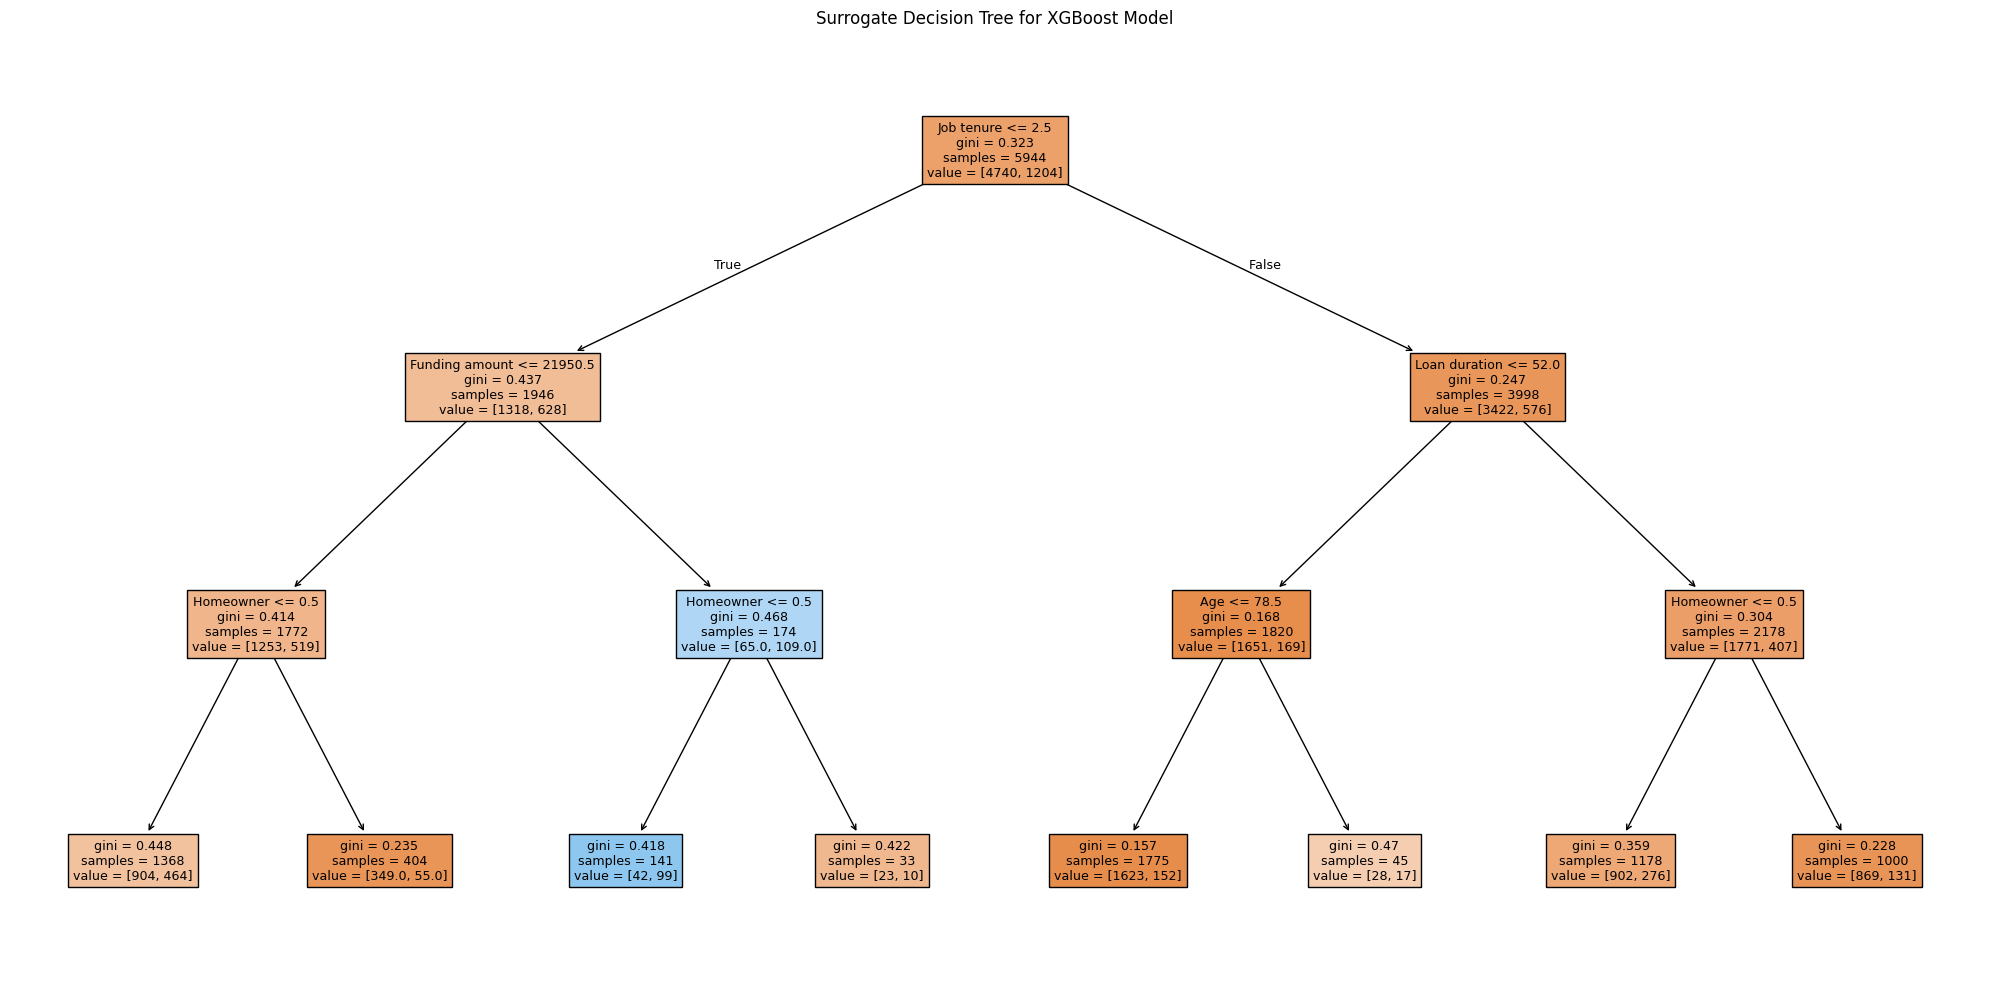

In [42]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn import tree

# Create and train the surrogate decision tree model
surrogate_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
surrogate_tree.fit(X_train, y_train)  # Fit directly on the original target variable

# Evaluate the model performance
dt_train_accuracy = accuracy_score(y_train, surrogate_tree.predict(X_train))
dt_test_accuracy = accuracy_score(y_test, surrogate_tree.predict(X_test))

# Display results
print(f"Accuracy of the decision tree model on training data: {dt_train_accuracy:.4f}")
print(f"Accuracy of the decision tree model on test data: {dt_test_accuracy:.4f}")

# Visualize the surrogate decision tree
plt.figure(figsize=(20,10))
tree.plot_tree(surrogate_tree, feature_names=X.columns, filled=True)
plt.title('Surrogate Decision Tree for XGBoost Model')
plt.savefig('surrogate_tree_xgboost_model.png') 
plt.show()


## Step 5: Global interpretability: Implement the PDP method to interpret your own model. Compare the results provided in Steps 4 and 5.

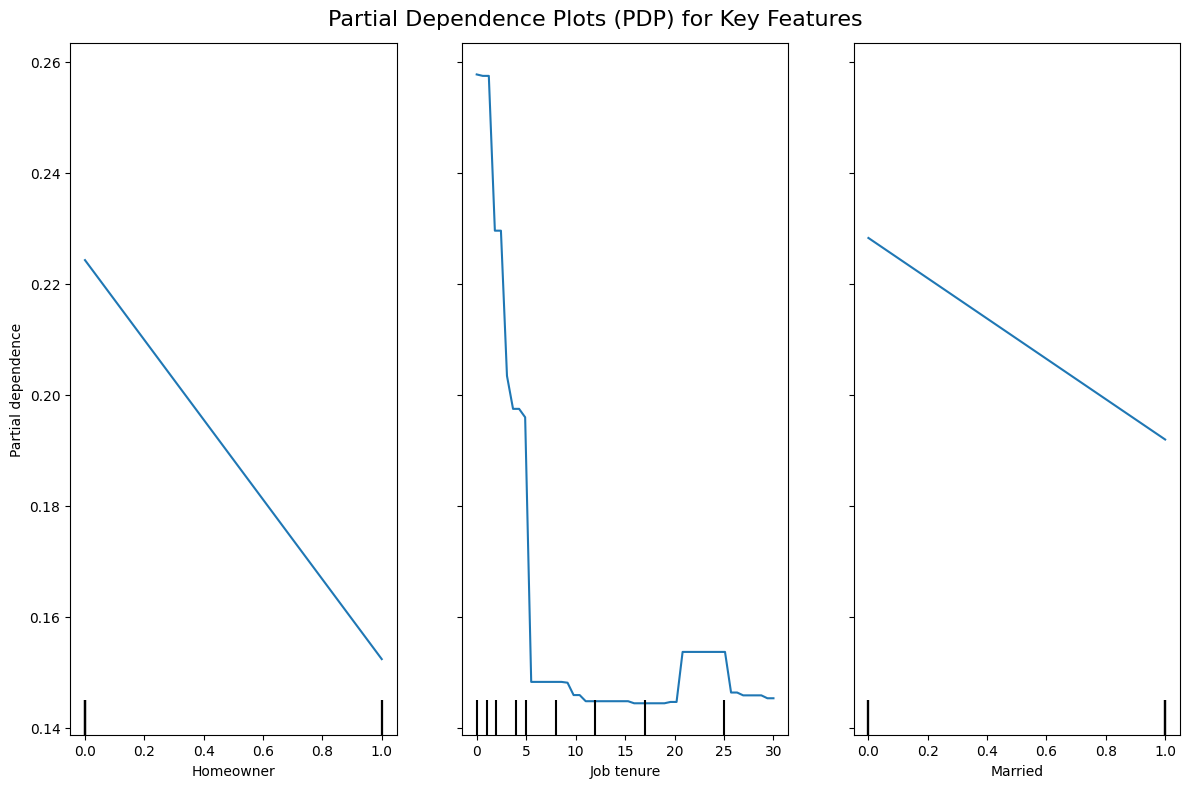

In [43]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Select the top 3 most important features for PDPs
features_to_plot = importances.head(3).index.tolist()

# Calculate and plot the PDPs using PartialDependenceDisplay
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(xgb_model, X_train, features_to_plot, grid_resolution=50, ax=ax)

# Add titles and labels for better presentation
plt.suptitle('Partial Dependence Plots (PDP) for Key Features', fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()


## Step 6: Local interpretability: Implement the ICE method to interpret your own model.

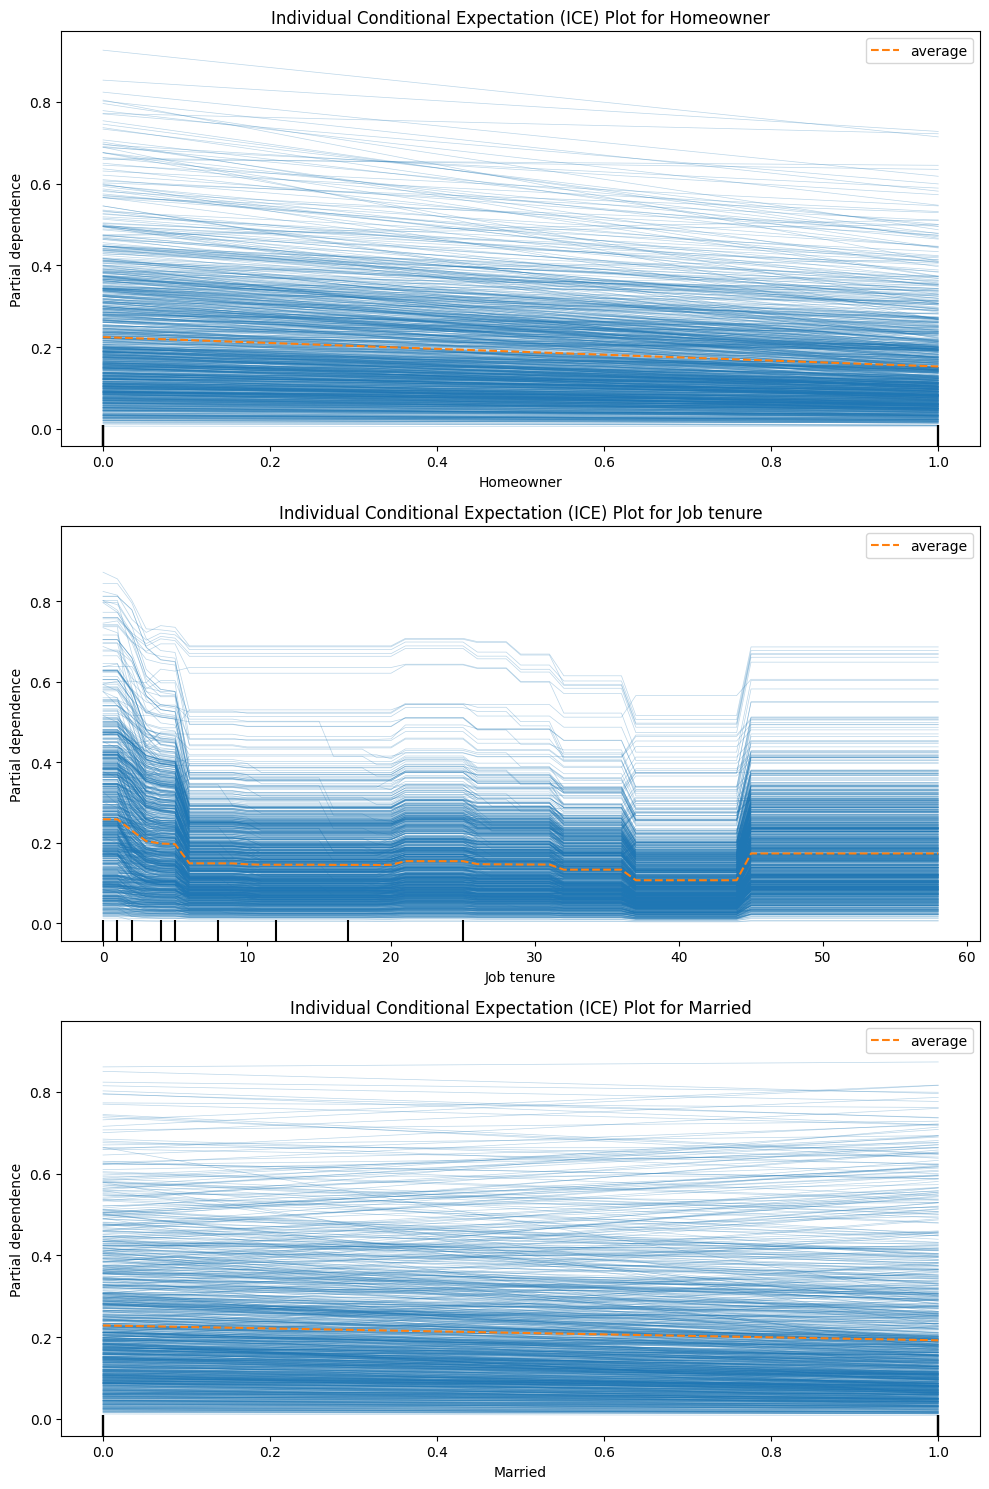

ICE plots have been generated for the following features:
Homeowner, Job tenure, Married


In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.inspection import PartialDependenceDisplay

# Define the features to plot ICE for
features = ['Homeowner', 'Job tenure', 'Married']

# Generate ICE plots for each feature
fig, ax = plt.subplots(len(features), figsize=(10, 15))

for i, feature in enumerate(features):
    # Create the ICE plot for the current feature
    PartialDependenceDisplay.from_estimator(xgb_model, X_train, [feature], kind="both", ax=ax[i])
    ax[i].set_title(f'Individual Conditional Expectation (ICE) Plot for {feature}')
    ax[i].grid(True)

plt.tight_layout()
plt.savefig('ice_plots_xgboost.png')  # Save the figure for presentation
plt.show()

# Optionally, summarize the observations from the ICE plots
print("ICE plots have been generated for the following features:")
print(", ".join(features))

## Step 7: Local interpretability: Implement the SHAP method to interpret your own model. Compare the results provided in Steps 6 and 7.

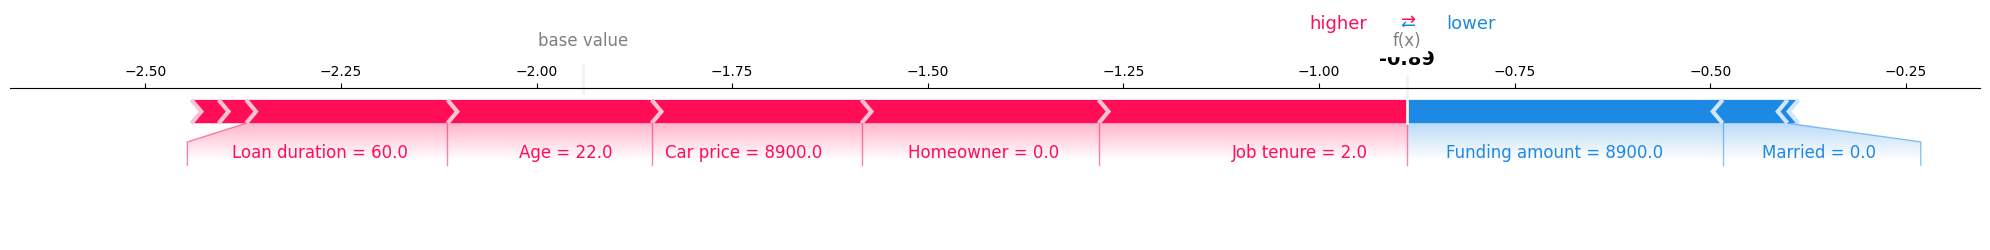

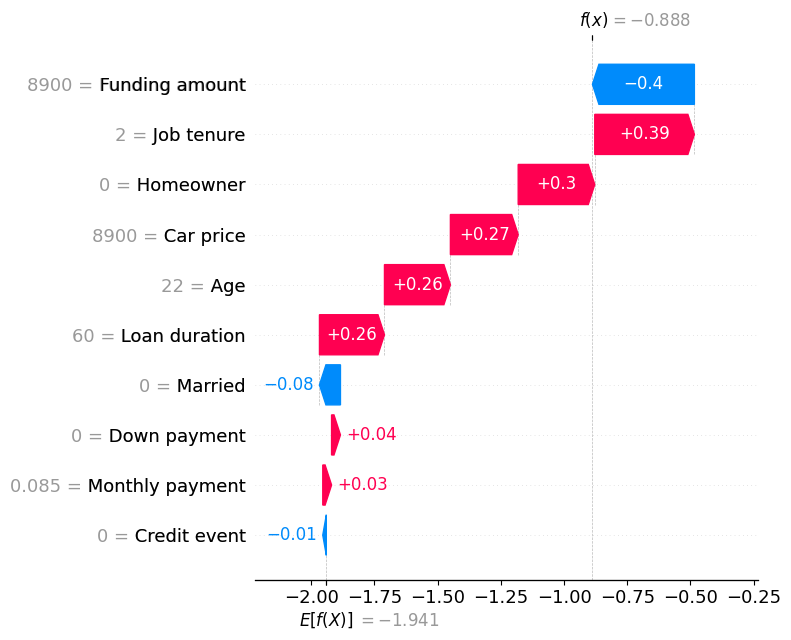

In [45]:
import shap
import matplotlib.pyplot as plt

# Initialize the SHAP explainer
explainer = shap.Explainer(xgb_model, X_train)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)

# Summary plot for SHAP values - Bar plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title('SHAP Summary Plot (Bar) for XGBoost Model')
plt.tight_layout()
plt.savefig('shap_summary_plot_bar_xgboost.png')
plt.close()

# Detailed SHAP summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, show=False)
plt.title('SHAP Summary Plot (Detailed) for XGBoost Model')
plt.tight_layout()
plt.savefig('shap_summary_plot_detailed_xgboost.png')
plt.close()

# SHAP force plot for a single instance
instance_idx = 0  # Choose the first instance in the test set
shap.force_plot(explainer.expected_value, shap_values[instance_idx].values, X_test.iloc[instance_idx], 
                matplotlib=True, show=True)

# Waterfall plot for a specific instance
shap.plots.waterfall(shap_values[instance_idx], show=True)


## Step 8: Performance interpretability: Implement the permutation importance method and/or the XPER method to identify the main drivers of the predictive performance of your model. Are the drivers of the performance metric (Step 8) similar to the drivers of the individual forecasts identified by SHAP (Step 7).

Performing Computation:   0%|          | 0/1 [00:00<?, ?it/s]

1022


Performing Computation: 100%|██████████| 1/1 [01:11<00:00, 71.45s/it]


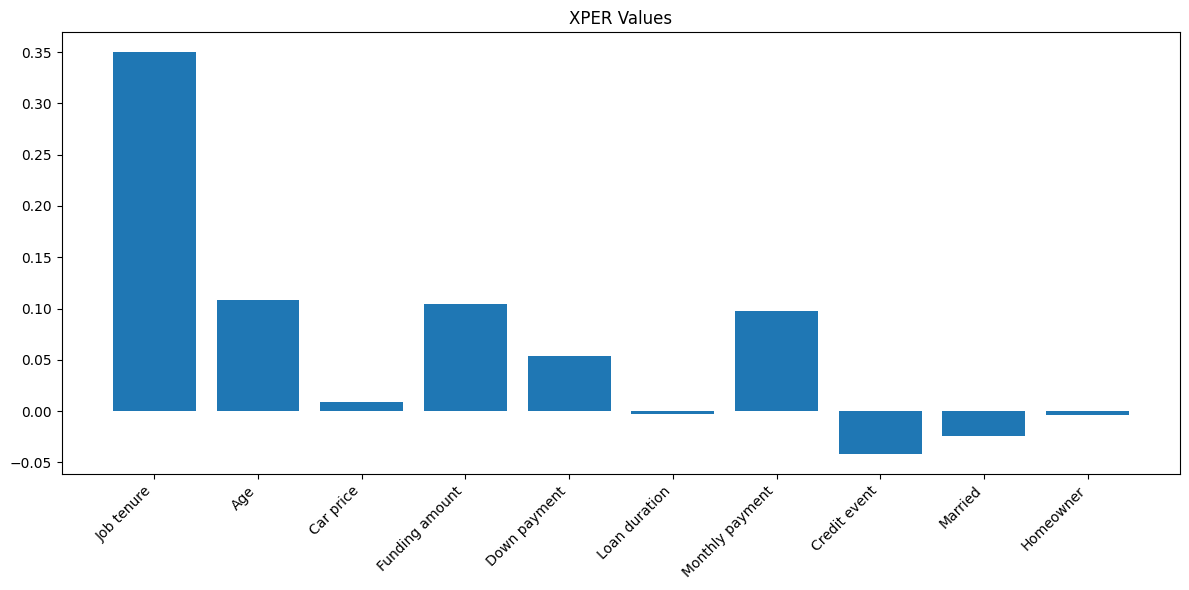

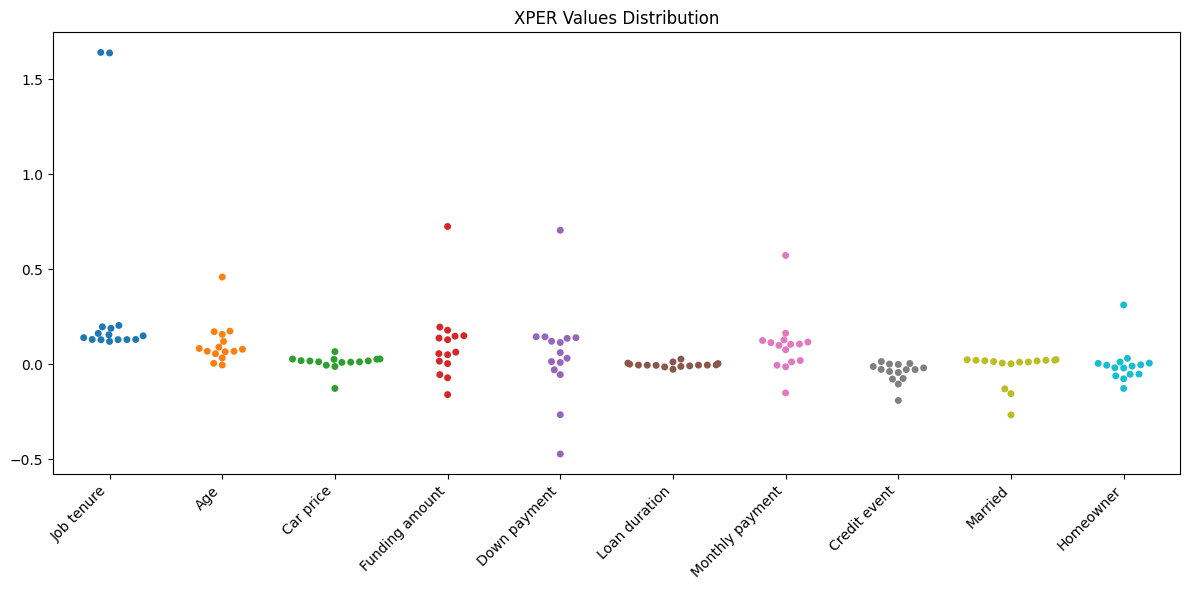

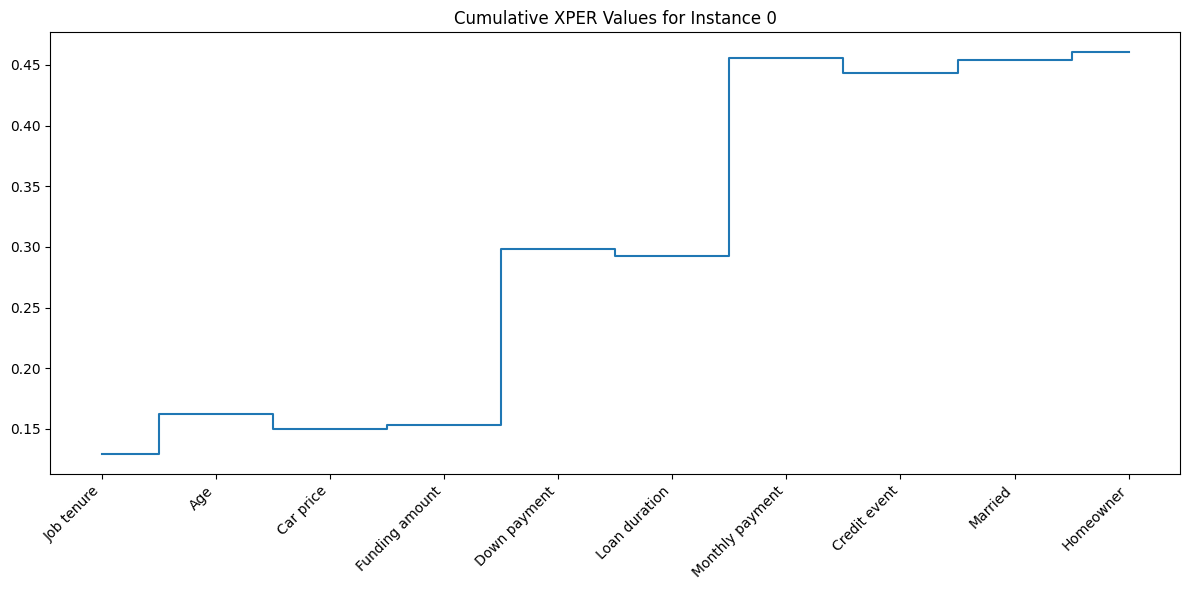

Custom XPER plots have been generated for detailed analysis and presentation.


In [46]:
from XPER.compute.Performance import ModelPerformance
from XPER.viz.Visualisation import visualizationClass as viz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Custom visualization functions
def custom_bar_plot(XPER_values, labels):
    plt.figure(figsize=(12, 6))
    plt.bar(labels, XPER_values.flatten())
    plt.xticks(rotation=45, ha='right')
    plt.title('XPER Values')
    plt.tight_layout()
    plt.show()

def custom_beeswarm_plot(XPER_values, labels):
    df = pd.DataFrame(XPER_values, columns=labels)
    plt.figure(figsize=(12, 6))
    sns.swarmplot(data=df)
    plt.xticks(rotation=45, ha='right')
    plt.title('XPER Values Distribution')
    plt.tight_layout()
    plt.show()

def custom_force_plot(XPER_values, instance, labels):
    values = XPER_values[instance]
    cumulative = np.cumsum(values)
    plt.figure(figsize=(12, 6))
    plt.step(range(len(cumulative)), cumulative, where='mid')
    plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
    plt.title(f'Cumulative XPER Values for Instance {instance}')
    plt.tight_layout()
    plt.show()

# Use a subset of your data to reduce runtime (e.g., 1% of the data)
train_sample = X_train.sample(frac=0.01, random_state=42)  # Sample from X_train
X_train_small = train_sample.reset_index(drop=True)        # Reset index for X_train
y_train_small = y_train.loc[train_sample.index].reset_index(drop=True)  # Subset and reset index for y_train

test_sample = X_test.sample(frac=0.01, random_state=42)    # Sample from X_test
X_test_small = test_sample.reset_index(drop=True)          # Reset index for X_test
y_test_small = y_test.loc[test_sample.index].reset_index(drop=True)    # Subset and reset index for y_test

# Initialize the XPER object with the smaller dataset
XPER_ = ModelPerformance(X_train_small.values, y_train_small.values, X_test_small.values, y_test_small.values, xgb_model)

# Calculate XPER values for the model's performance
XPER_values = XPER_.calculate_XPER_values(["AUC"])  # Use "AUC" or another metric of interest

# Extract the aggregated and individual contributions
XPER_values_aggregated = XPER_values[0]
XPER_values_individual = XPER_values[1]

# Ensure that the number of features matches between the XPER values and the data
if len(XPER_values_aggregated) != len(X_test_small.columns):
    XPER_values_aggregated = XPER_values_aggregated[:len(X_test_small.columns)]

if XPER_values_individual.shape[1] != len(X_test_small.columns):
    XPER_values_individual = XPER_values_individual[:, :len(X_test_small.columns)]

# Generate custom visualizations
try:
    # Custom bar plot
    custom_bar_plot(XPER_values_aggregated, X_test_small.columns)
    
    # Custom beeswarm plot
    custom_beeswarm_plot(XPER_values_individual, X_test_small.columns)
    
    # Custom force plot
    custom_force_plot(XPER_values_individual, 0, X_test_small.columns)
    
    print("Custom XPER plots have been generated for detailed analysis and presentation.")

except Exception as e:
    print(f"An error occurred: {e}")


## Step 9: Assess the fairness of your own model with respect to age (protected attribute). Use a statistical test for the following three fairness definitions: Statistical Parity and Conditional Statistical Parity (groups are given in the dataset). Discuss your results.

In [48]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

# 1. Group ages into two categories (e.g., under 40 and 40 and above)
data['Age Group'] = np.where(data['Age'] < 40, 'Under 40', '40 and above')

# 2. Statistical Parity: Check if the predicted default probability is similar across age groups
parity_table = pd.crosstab(data['Age Group'], data['Default (y)'])
chi2, p_value, dof, expected = chi2_contingency(parity_table)
print(f"Chi2 Statistic for Statistical Parity: {chi2}, p-value: {p_value}")

if p_value < 0.05:
    print("There is a statistically significant difference between age groups in terms of statistical parity.")
else:
    print("No statistically significant difference observed between age groups in terms of statistical parity.")

# 3. Conditional Statistical Parity: Control for another variable (e.g., homeowner status)
parity_table_conditional = pd.crosstab([data['Age Group'], data['Homeowner']], data['Default (y)'])
chi2_conditional, p_value_conditional, dof_conditional, expected_conditional = chi2_contingency(parity_table_conditional)
print(f"\nChi2 Statistic for Conditional Statistical Parity: {chi2_conditional}, p-value: {p_value_conditional}")

if p_value_conditional < 0.05:
    print("There is a statistically significant difference between age groups in terms of conditional statistical parity.")
else:
    print("No statistically significant difference observed between age groups in terms of conditional statistical parity.")


Chi2 Statistic for Statistical Parity: 218.3368137948817, p-value: 2.085321579570196e-49
There is a statistically significant difference between age groups in terms of statistical parity.

Chi2 Statistic for Conditional Statistical Parity: 359.00637292712577, p-value: 1.6728325620993856e-77
There is a statistically significant difference between age groups in terms of conditional statistical parity.


## Step 10: Implement a FPDP using a fairness measure. Discuss your results.

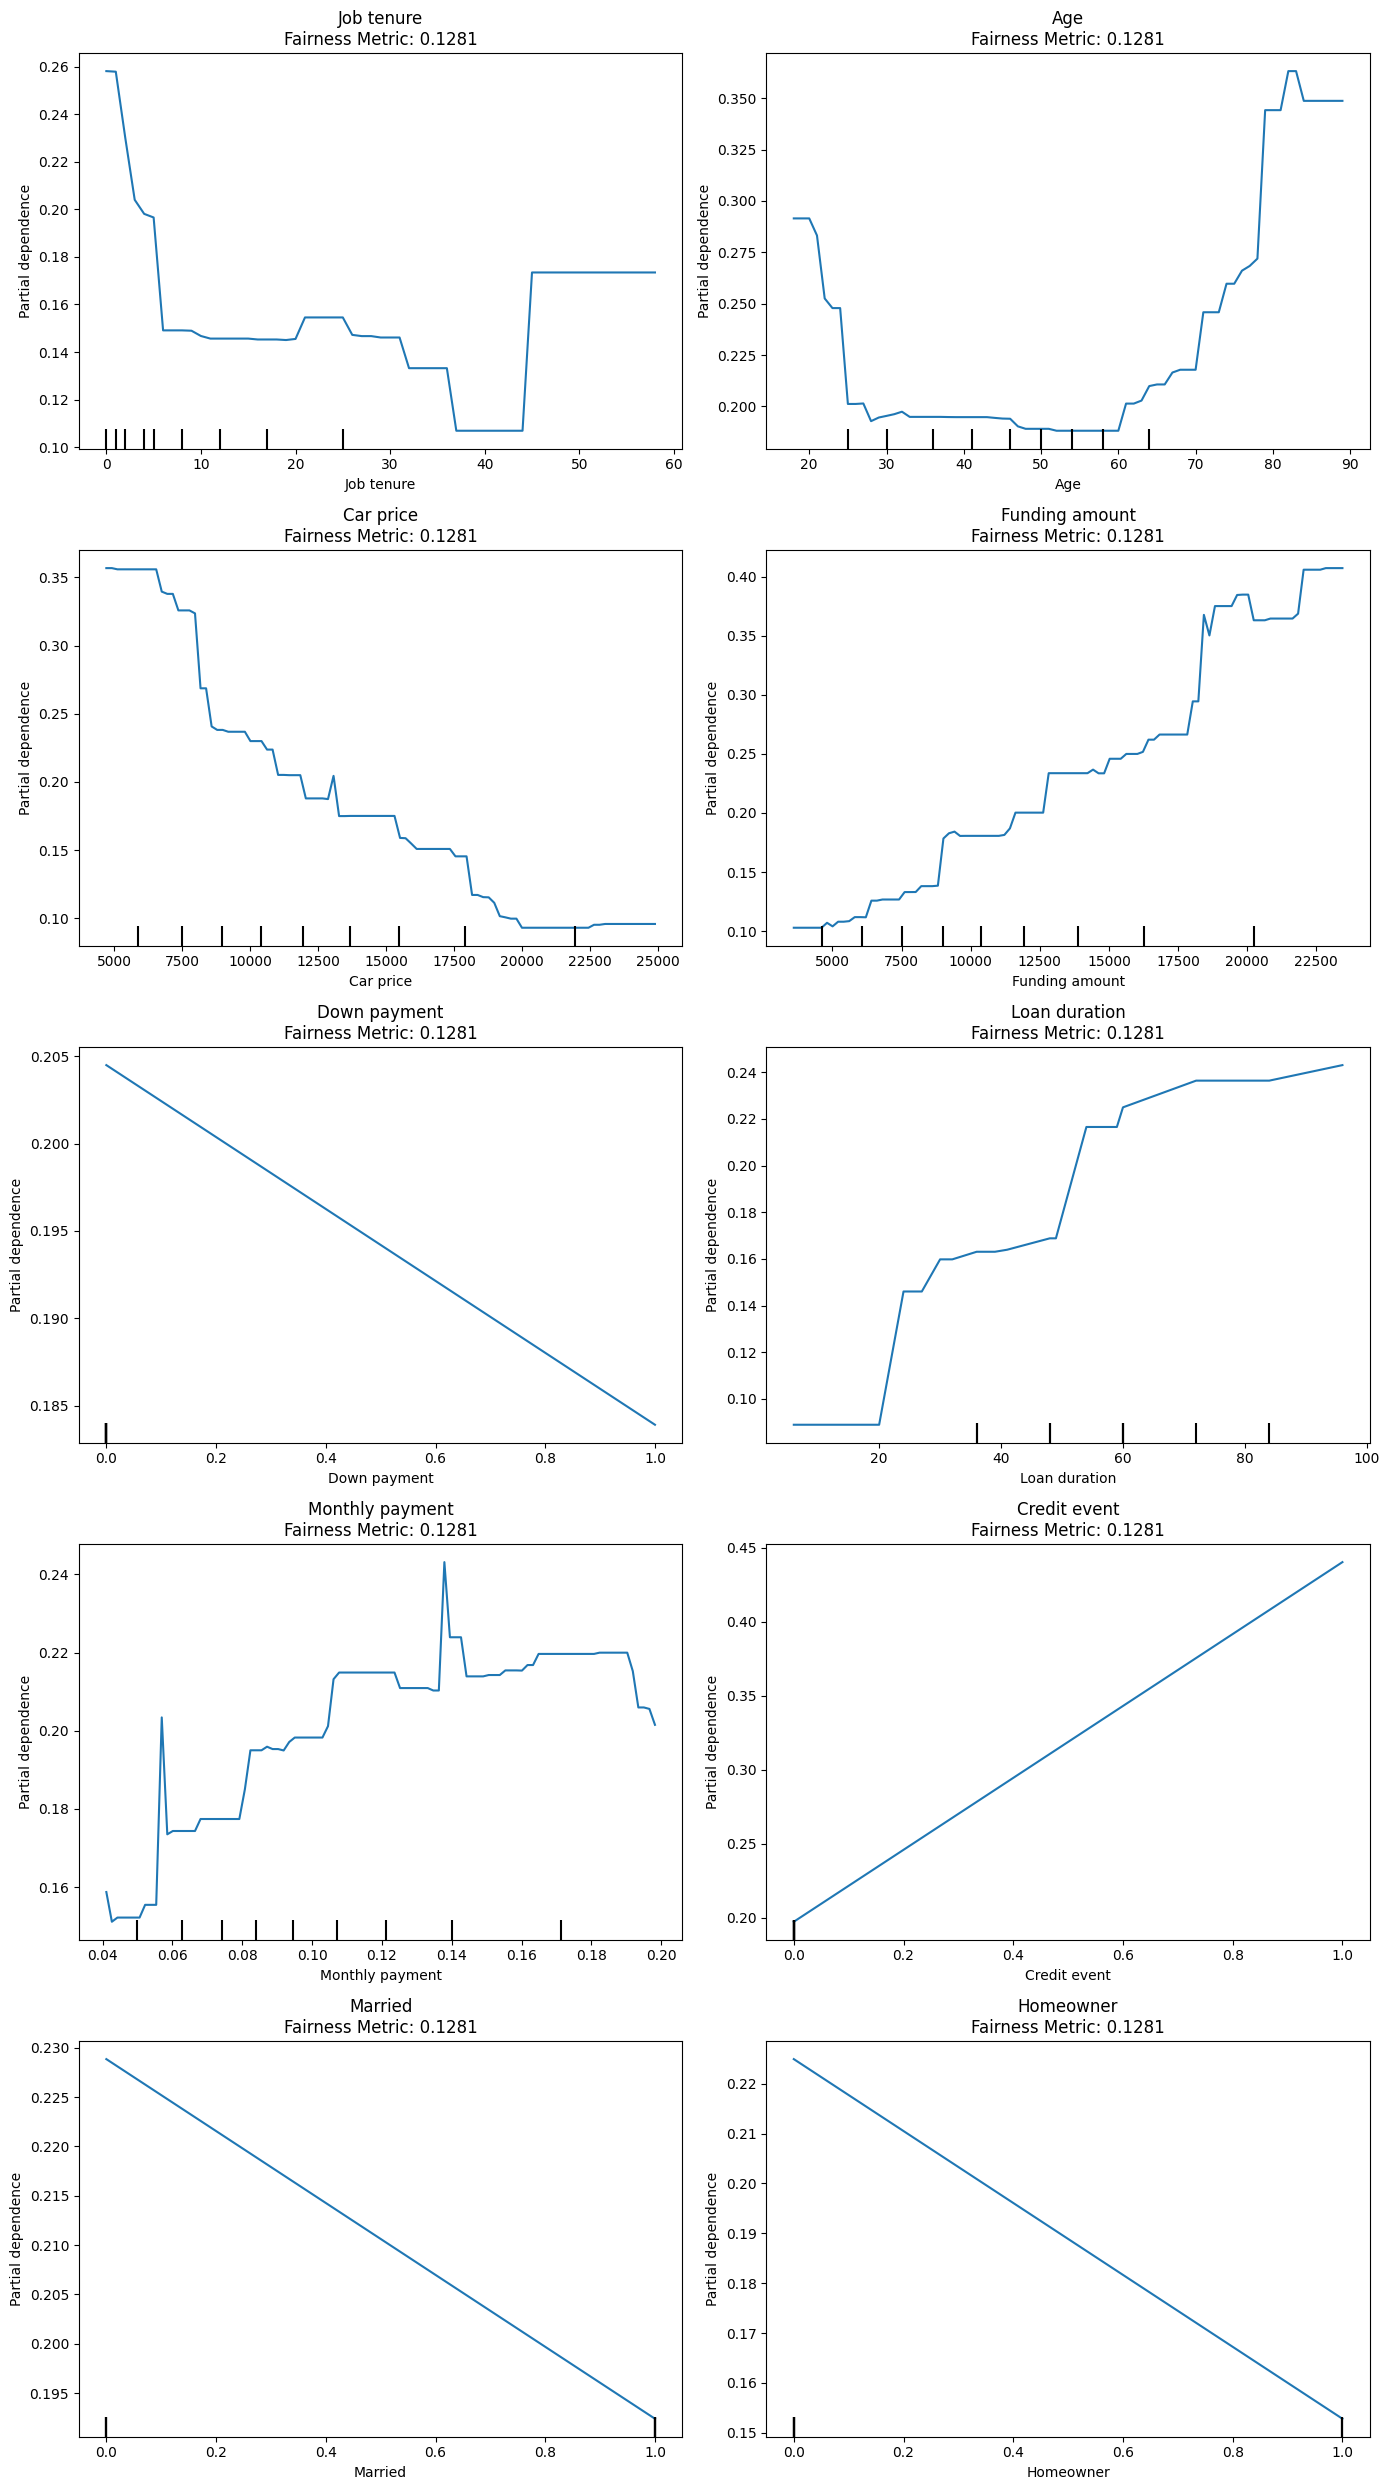

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# The features to analyze and the protected attribute
features_to_analyze = ['Job tenure', 'Age', 'Car price', 'Funding amount', 
                       'Down payment', 'Loan duration', 'Monthly payment', 
                       'Credit event', 'Married', 'Homeowner']

# Function to plot FPDP
def fairness_partial_dependence_plot(model, X, features, protected_attribute):
    fig, axes = plt.subplots(len(features) // 2, 2, figsize=(14, len(features) * 2.5))
    axes = axes.flatten()
    
    for i, feature in enumerate(features):
        # Create the PDP
        PartialDependenceDisplay.from_estimator(model, X, [feature], ax=axes[i])
        
        # Calculate average predictions for the two groups
        group_1 = X[X[protected_attribute] < 40]  # Under 40 years old
        group_2 = X[X[protected_attribute] >= 40]  # 40 years old and above
        
        avg_pred_group_1 = model.predict_proba(group_1)[:, 1].mean()
        avg_pred_group_2 = model.predict_proba(group_2)[:, 1].mean()
        
        # Calculate the difference between the groups
        fairness_metric = np.abs(avg_pred_group_1 - avg_pred_group_2)
        
        # Annotate the fairness metric on the plot
        axes[i].set_title(f'{feature}\nFairness Metric: {fairness_metric:.4f}')
        axes[i].set_ylabel('Partial Dependence')
    
    plt.tight_layout()
    plt.show()

# Use FPDP on the available features
fairness_partial_dependence_plot(
    model=xgb_model, 
    X=X, 
    features=features_to_analyze, 
    protected_attribute='Age'  # Protected attribute to evaluate fairness
)
